# Load Data

In [151]:
import pickle
import numpy as np
import pandas as pd
import time
import os
from feature_utils import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from pprint import pprint
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE


def picklereader(fpath):
    with open(fpath,'rb') as f:
        content = pd.read_pickle(f)
    return content

df = picklereader(os.getcwd()+'/data/df18S_rs_reduce.p')

In [2]:
df.head()

,gender,age,vessel,seg,OS_PB40,OS_PB70,OS_MLA,MLA,EEM_MLA,PB_MLA,...,area1_stenosis_dist5,area3_stenosis_aver,RI_MLA_ref,RI_MLA_prox5,variance_lumen_worst,variance_lumen_PB40,variance_plaque_worst,variance_plaque_PB40,long_eccentricity_worst,long_eccentricity_PB40
0,1,59,1,1,0,0,791,5.480974,23.524774,0.767013,...,0.646114,0.160654,0.000000,0.000000,0.517217,7.890320,1.187166,7.783799,0.072780,0.383794
1,2,73,1,2,0,0,2272,2.433403,6.934078,0.649066,...,0.000000,0.000000,0.000000,0.000000,0.097784,5.809565,0.050160,2.131793,0.058916,0.892380
2,1,61,1,2,0,44,249,2.070309,13.862166,0.850650,...,0.000000,0.000000,0.000000,0.000000,1.212633,0.903290,2.197129,6.271595,0.046846,0.077764
3,1,61,3,2,0,1170,1338,2.384325,10.941244,0.782079,...,0.000000,0.000000,0.000000,0.000000,0.194207,2.302834,0.036625,0.995525,0.041690,0.371873
4,1,60,1,2,525,0,856,2.991094,16.061737,0.813775,...,0.565989,0.464287,1.023542,0.780071,2.968152,16.178021,2.637238,3.715845,0.069930,0.154312


In [3]:
df.shape

(1447, 65)

In [4]:
# check there are no null values
print(df.isnull().sum().to_string())

gender                     0
age                        0
vessel                     0
seg                        0
OS_PB40                    0
OS_PB70                    0
OS_MLA                     0
MLA                        0
EEM_MLA                    0
PB_MLA                     0
No_PB40                    0
No_PB70                    0
No_lumen40_ROI             0
No_lumen25_ROI             0
No_lumen30_ROI             0
Sum_plaque_ROI             0
Sum_EEM_ROI                0
PB_ROI                     0
mean_lumen_ROI             0
mean_plaque_ROI            0
mean_EEM_ROI               0
Sum_plaque_PB40            0
Sum_EEM_PB40               0
mean_lumen_PB40            0
mean_EEM_PB40              0
No_lumen40_PB70            0
No_lumen25_PB70            0
No_lumen30_PB70            0
Sum_plaque_PB70            0
PB_PB70                    0
mean_lumen_PB70            0
No_lumen40_worst           0
No_lumen25_worst           0
Sum_plaque_worst           0
Sum_EEM_worst 

# Random Forest Classifier

No PCA, no validation, 80/20 split

In [5]:
# split train validation test
df1 = picklereader(os.getcwd()+'/data/df18S_rs_extract.p')
y = df1['ffr_80']
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
print('Training features:',X_train.shape)
print('Training labels:',y_train.shape)
print('Test features:',X_test.shape)
print('Test labels:',y_test.shape)

Training features: (1157, 65)
Training labels: (1157,)
Test features: (290, 65)
Test labels: (290,)


In [6]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, y_train)
predictions2 = clf.predict(X_test)

In [8]:
cm = pd.crosstab(y_test, predictions2, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,170,18
1,63,39


In [9]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.72
FNR: 0.62
Recall: 0.38
Precision: 0.68
F1: 0.49


Accuracy measure the number of true correct classifications.
FNR False Negative Rate also known as specificity measures the probability of a negative test result given that the condition is postive.
Precision (P) is defined as the number of true positives (T_p) over the number of true positives plus the number of false positives (F_p).  
Recall (R) is defined as the number of true positives (T_p) over the number of true positives plus the number of false negatives (F_n).  
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.  

In [10]:
# View a list of the features and their importance scores
list(zip(X_train, clf.feature_importances_))

[('gender', 0.0080262674831912285),
 ('age', 0.049909128157430656),
 ('vessel', 0.015116874303115488),
 ('seg', 0.0059280363697237432),
 ('OS_PB40', 0.0047325765185182002),
 ('OS_PB70', 0.016625117443352749),
 ('OS_MLA', 0.022055753481032926),
 ('MLA', 0.032343891830318106),
 ('EEM_MLA', 0.021649860111149735),
 ('PB_MLA', 0.018133442854030547),
 ('No_PB40', 0.013958663189924333),
 ('No_PB70', 0.029357002848865554),
 ('No_lumen40_ROI', 0.023994913198294335),
 ('No_lumen25_ROI', 0.040338717510325951),
 ('No_lumen30_ROI', 0.036220300417726913),
 ('Sum_plaque_ROI', 0.019037705082789166),
 ('Sum_EEM_ROI', 0.025947418889883594),
 ('PB_ROI', 0.02041938985094701),
 ('mean_lumen_ROI', 0.026352527552118747),
 ('mean_plaque_ROI', 0.013625513759456333),
 ('mean_EEM_ROI', 0.018857481347113351),
 ('Sum_plaque_PB40', 0.016676980251901594),
 ('Sum_EEM_PB40', 0.012607085434256737),
 ('mean_lumen_PB40', 0.027931035792051639),
 ('mean_EEM_PB40', 0.012997028243023599),
 ('No_lumen40_PB70', 0.0185394476049

# Random Forest Classifier Model3

balanced parameter

In [11]:
clf3 = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=0)
clf3.fit(X_train, y_train)
predictions3 = clf3.predict(X_test)
cm = pd.crosstab(y_test, predictions3, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,172,16
1,60,42


In [12]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.74
FNR: 0.59
Recall: 0.41
Precision: 0.72
F1: 0.52


# Random Forest Classifier Model6
Hypertuning

In [13]:
clf6 = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=0)
print('Parameters currently in use:\n')
pprint(clf6.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [14]:


# number of trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max number of features to consider at every split
max_features = ['auto', 'sqrt']
# max number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# min number of samples required to split a node
min_samples_split = [2, 5, 10]
# min number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]
# create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [15]:
# random search of parameters, using 5 fold cross validation, 
# search across 10 different combinations, and use all available cores
clf6_random = RandomizedSearchCV(estimator = clf6, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf6_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.6s


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, total=   4.2s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, total=   3.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, total=   3.9s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   1.9s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1000, m

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [16]:
clf6_random.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [17]:
clf6_best_random = clf6_random.best_estimator_
predictions6 = clf6_best_random.predict(X_test)
cm = pd.crosstab(y_test, predictions6, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,171,17
1,51,51


In [18]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.77
FNR: 0.5
Recall: 0.5
Precision: 0.75
F1: 0.6


We see a big improvement in this initially tuned model compared to the previous models where we did not reduce the features. The F1 score increased 17% and the accuracy increased 4%. We see an increase in the recall score as a result of less false negatives.

In [20]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110, 120],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 3],
    'n_estimators': [1100, 1200, 1300, 1400]
}
# Create a based model
clf6 = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=0)
# Instantiate the grid search model
clf6_grid_search = GridSearchCV(estimator = clf6, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [21]:
clf6_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1100 
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1100 
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1100 
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1100 
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1100 
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200 
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200 
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=True, max_

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.8s


[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=   8.7s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1300 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=   8.9s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1300 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=   9.3s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=   9.3s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1400, total=  12.7s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1100, total=   9.1s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1100, total=   9.2s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1400, total=  12.2s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1300 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1300, total=   9.8s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1100 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1300, total=  10.0s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1100 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1400, total=  11.1s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1100 
[CV]  bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1400, total=  11.5s
[CV] bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1100 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=   9.3s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=   9.8s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=   9.9s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1300, total=  12.2s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.4min


[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=   9.6s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1300 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=   9.3s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=   9.5s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=  10.4s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=True

[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1400, total=  13.1s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1100, total=   9.2s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1100, total=   9.4s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1300 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1100, total=  10.3s
[CV] bootstrap=True,

[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1300, total=   9.9s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1100 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1300, total=  11.2s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1100 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1400, total=  12.0s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1100 
[CV]  bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1400, total=  11.8s
[CV] bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1100 
[CV]  bootstrap=True

[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1300 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=  10.1s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=  10.4s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1200, total=  10.9s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1300, total=  12.0s
[CV] bootstrap=True,

[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1400, total=  12.9s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1100, total=  10.7s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1100, total=  10.3s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1300 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1100, total=  10.4s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1300 
[CV]  bootstrap=True

[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1100 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1300, total=  10.5s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1100 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1400, total=  12.2s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1100 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1400, total=  12.3s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1100 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1400, total=  12.5s
[CV] bootstrap=True,

[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1200, total=   9.6s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1200, total=   9.5s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1400 


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  8.4min


[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1200, total=   9.9s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1300, total=  12.0s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1300, total=  11.6s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1400 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1300, total=  10.8s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=1100 
[CV]  bootstrap=True

[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1300 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1100, total=  11.6s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1300 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1100, total=  11.5s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1300 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=  11.3s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1300 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=1200, total=  10.7s
[CV] bootstrap=True,

[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1400, total=  13.3s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1100 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1400, total=  14.6s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1100, total=  10.9s
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1400, total=  15.1s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1200 
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1200 
[CV]  bootstrap=True

[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1300, total=  13.3s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1300, total=  14.9s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1400 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1300, total=  14.0s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=5, min_samples_split=3, n_estimators=1100 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1300, total=  13.8s
[CV] bootstrap=True,

[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 12.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [90, 100, 110, 120], 'max_features': ['auto'], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [2, 3], 'n_estimators': [1100, 1200, 1300, 1400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [22]:
clf6_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [24]:
clf6_best_grid = clf6_grid_search.best_estimator_
predictions6 = clf6_best_grid.predict(X_test)
cm = pd.crosstab(y_test, predictions6, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,170,18
1,48,54


In [25]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.77
FNR: 0.47
Recall: 0.53
Precision: 0.75
F1: 0.62


Our hypertuned random forest model predicts with an accuracy of 77%, recall 0.53, and F! 0.62. This model is an improvement on all prior models to date especially because of less false negatives. The FNR is 0.47 compared to the base random forest which had an FNR of 0.62 (-24% improvement)

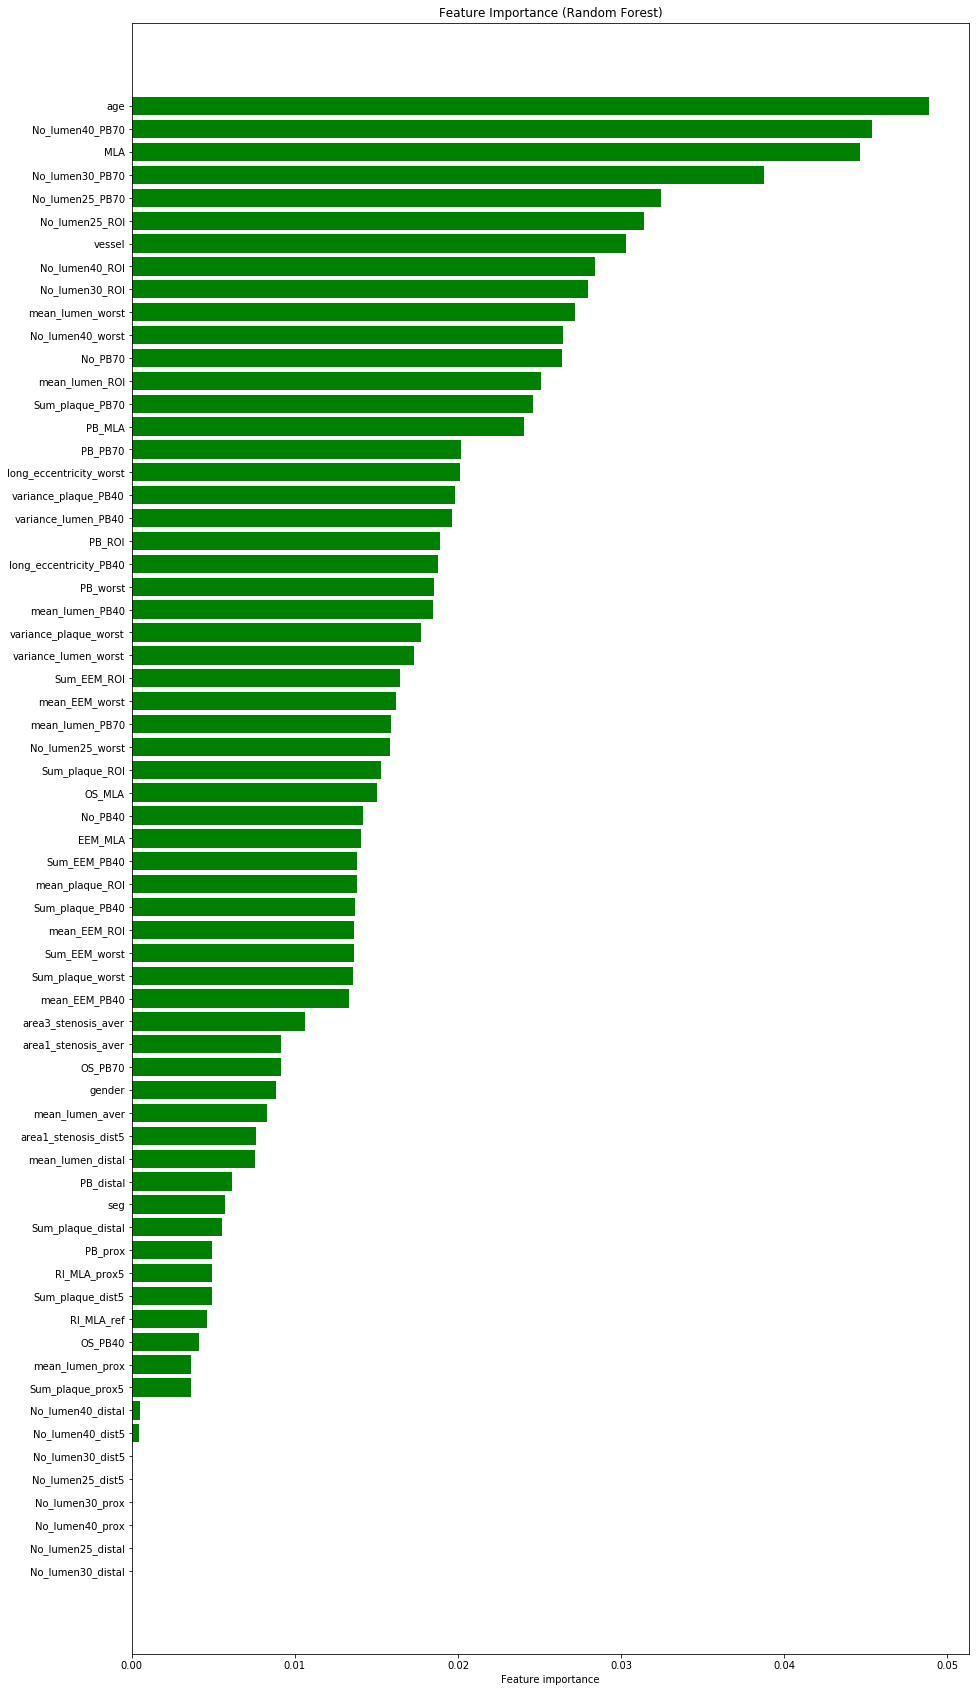

In [26]:
df = list(zip(X_train, clf6_best_grid.feature_importances_))
df = pd.DataFrame(df, columns=['feat','fe'])
dfs = df.sort_values('fe',ascending=False) #sort by the column 'fe'

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 30))
features = list(dfs.feat)
y_pos = np.arange(len(features))
x = dfs.fe
ax.barh(y_pos, x, xerr=None, align='center',color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importance')
ax.set_title('Feature Importance (Random Forest)')
plt.show()

# Support Vector Machine Model7
basic parameters

In [5]:
from sklearn import svm

In [64]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

X_norm = (X_train - X_train.mean()) / (X_train.max() - X_train.min())
clf7 = svm.SVC(kernel='linear', C=1, gamma=1,random_state=0) 
clf7.fit(X_norm, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [65]:
predictions7 = clf7.predict(X_test)
cm = pd.crosstab(y_test, predictions7, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,159,29
1,95,7


In [66]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.57
FNR: 0.93
Recall: 0.07
Precision: 0.19
F1: 0.1


# Support Vector Machine Model8
rbf kernel with SMOTE oversampling

In [233]:
sm = SMOTE(random_state=12, ratio = 'minority')
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_norm = (X_train_res - X_train_res.mean()) / (X_train_res.max() - X_train_res.min())
clf8 = svm.SVC(kernel='poly', degree=3, C=1, gamma=2,random_state=0) 
clf8.fit(X_norm, y_train_res)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='poly',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [234]:
predictions8 = clf8.predict(X_test)
cm = pd.crosstab(y_test, predictions8, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,179,9
1,76,26


In [235]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.71
FNR: 0.75
Recall: 0.25
Precision: 0.74
F1: 0.38


# Support Vector Machine Model9
poly kernel with 4th degree

In [81]:
clf9 = svm.SVC(kernel='poly', C=1, gamma=1, class_weight='balanced',random_state=0,degree=4) 
clf9.fit(X_norm, y_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=4, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [83]:
predictions9 = clf9.predict(X_test)
cm = pd.crosstab(y_test, predictions9, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,183,5
1,86,16


In [84]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.69
FNR: 0.84
Recall: 0.16
Precision: 0.76
F1: 0.26


The class imbalance makes the SVM perform poorly.

# AdaBoost Model10

In [85]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=0)
clf10 = AdaBoostClassifier(n_estimators=100, base_estimator=rf,learning_rate=1)
clf10.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
          learning_rate=1, n_estimators=100, random_state=None)

In [88]:
predictions10 = clf10.predict(X_test)
cm = pd.crosstab(y_test, predictions10, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,172,16
1,54,48


In [89]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.76
FNR: 0.53
Recall: 0.47
Precision: 0.75
F1: 0.58


The base adaboost model performs slightly less than the tuned random forest.

# AdaBoost Model11


In [90]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=0,bootstrap=True,max_depth=90, max_features='auto', min_samples_leaf=5, min_samples_split=2,n_estimators=1200 )
clf11 = AdaBoostClassifier(base_estimator=rf,learning_rate=1)
print('Parameters currently in use:\n')
pprint(clf11.get_params())

Parameters currently in use:

{'algorithm': 'SAMME.R',
 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=90, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1200, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
 'base_estimator__bootstrap': True,
 'base_estimator__class_weight': 'balanced',
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 90,
 'base_estimator__max_features': 'auto',
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 5,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__n_estimators': 1200,
 'b

In [91]:
# number of trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# max number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# max number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# min number of samples required to split a node
min_samples_split = [2, 5, 10]
# min number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]
#learning rate
learning_rate = [0.01,0.05,0.1,0.3,1]
# create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               'base_estimator__bootstrap': bootstrap}
pprint(random_grid)

{'base_estimator__bootstrap': [True, False],
 'base_estimator__max_depth': [10,
                               20,
                               30,
                               40,
                               50,
                               60,
                               70,
                               80,
                               90,
                               100,
                               110,
                               None],
 'base_estimator__max_features': ['auto', 'sqrt', 'log2'],
 'base_estimator__min_samples_leaf': [1, 2, 4],
 'base_estimator__min_samples_split': [2, 5, 10],
 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [92]:
# random search of parameters, using 5 fold cross validation, 
# search across 10 different combinations, and use all available cores
clf11_random = RandomizedSearchCV(estimator = clf11, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf11_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=944, learning_rate=0.01, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=2, base_estimator__max_features=sqrt, base_estimator__max_depth=60, base_estimator__bootstrap=False 
[CV] n_estimators=944, learning_rate=0.01, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=2, base_estimator__max_features=sqrt, base_estimator__max_depth=60, base_estimator__bootstrap=False 
[CV] n_estimators=944, learning_rate=0.01, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=2, base_estimator__max_features=sqrt, base_estimator__max_depth=60, base_estimator__bootstrap=False 
[CV] n_estimators=944, learning_rate=0.01, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=2, base_estimator__max_features=sqrt, base_estimator__max_depth=60, base_estimator__bootstrap=False 
[CV] n_estimators=944, learning_rate=0.01, base_estimator__min_samples_split=10

[CV]  n_estimators=522, learning_rate=0.01, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=1, base_estimator__max_features=auto, base_estimator__max_depth=110, base_estimator__bootstrap=False, total=  11.7s
[CV] n_estimators=522, learning_rate=0.01, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=1, base_estimator__max_features=auto, base_estimator__max_depth=110, base_estimator__bootstrap=False 
[CV]  n_estimators=522, learning_rate=0.01, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=1, base_estimator__max_features=auto, base_estimator__max_depth=110, base_estimator__bootstrap=False, total=  11.8s
[CV] n_estimators=522, learning_rate=0.01, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=1, base_estimator__max_features=auto, base_estimator__max_depth=110, base_estimator__bootstrap=False 
[CV]  n_estimators=100, learning_rate=1, base_estimator__min_samples_split=10, base_estimator__min_samples

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.2min


[CV]  n_estimators=100, learning_rate=0.05, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=4, base_estimator__max_features=sqrt, base_estimator__max_depth=10, base_estimator__bootstrap=True, total= 5.6min
[CV] n_estimators=944, learning_rate=0.05, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=2, base_estimator__max_features=log2, base_estimator__max_depth=90, base_estimator__bootstrap=True 
[CV]  n_estimators=100, learning_rate=0.05, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=4, base_estimator__max_features=sqrt, base_estimator__max_depth=10, base_estimator__bootstrap=True, total= 5.9min
[CV] n_estimators=944, learning_rate=0.05, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=2, base_estimator__max_features=log2, base_estimator__max_depth=90, base_estimator__bootstrap=True 
[CV]  n_estimators=100, learning_rate=0.05, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf

[CV]  n_estimators=1155, learning_rate=0.05, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=4, base_estimator__max_features=sqrt, base_estimator__max_depth=50, base_estimator__bootstrap=True, total= 3.9min
[CV]  n_estimators=1155, learning_rate=0.05, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=4, base_estimator__max_features=sqrt, base_estimator__max_depth=50, base_estimator__bootstrap=True, total= 4.1min
[CV]  n_estimators=1155, learning_rate=0.05, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=4, base_estimator__max_features=sqrt, base_estimator__max_depth=50, base_estimator__bootstrap=True, total= 4.0min
[CV]  n_estimators=1155, learning_rate=0.05, base_estimator__min_samples_split=10, base_estimator__min_samples_leaf=4, base_estimator__max_features=sqrt, base_estimator__max_depth=50, base_estimator__bootstrap=True, total= 3.8min
[CV]  n_estimators=1155, learning_rate=0.05, base_estimator__min_samples_split=1

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=90, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None,...        verbose=0, warm_start=False),
          learning_rate=1, n_estimators=50, random_state=None),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'base_estimator__max_features': ['auto', 'sqrt', 'log2'], 'base_estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'base_estimator__min_samples_split': [2, 5, 10], 'base_estimator__min_samples_leaf': [1, 2, 4], 'base_estimator__bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42

In [93]:
clf11_random.best_params_

{'base_estimator__bootstrap': True,
 'base_estimator__max_depth': 40,
 'base_estimator__max_features': 'log2',
 'base_estimator__min_samples_leaf': 4,
 'base_estimator__min_samples_split': 10,
 'learning_rate': 1,
 'n_estimators': 100}

In [94]:
clf11_best_random = clf11_random.best_estimator_
predictions11 = clf11_best_random.predict(X_test)
cm = pd.crosstab(y_test, predictions11, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,169,19
1,47,55


In [95]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.77
FNR: 0.46
Recall: 0.54
Precision: 0.74
F1: 0.62


For comparison the tuned random forest  
Accuracy: 0.77  
FNR: 0.47  
Recall: 0.53  
Precision: 0.75  
F1: 0.62  

This tuned adaboost performs similarily to the tuned random forest. Interestingly, the parameters are slightly different with a larger min_samples_split (10) and a max_features (log2) and a small n_estimators (100)

# GradientBoost Model12

In [105]:
from sklearn.ensemble import GradientBoostingClassifier

clf12 = GradientBoostingClassifier()
clf12.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [106]:
predictions12 = clf12.predict(X_test)
cm = pd.crosstab(y_test, predictions12, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,171,17
1,43,59


In [107]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.79
FNR: 0.42
Recall: 0.58
Precision: 0.78
F1: 0.66


# GradientBoost Model13

In [109]:
clf13 = GradientBoostingClassifier(random_state=0)
print('Parameters currently in use:\n')
pprint(clf13.get_params())

Parameters currently in use:

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': 0,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}


In [121]:
random_grid = {
    'loss': ['deviance','exponential'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
}

In [122]:
clf13_random = RandomizedSearchCV(estimator = clf13, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
clf13_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=944, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, loss=exponential, learning_rate=0.3 
[CV] n_estimators=944, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, loss=exponential, learning_rate=0.3 
[CV] n_estimators=944, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, loss=exponential, learning_rate=0.3 
[CV] n_estimators=944, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, loss=exponential, learning_rate=0.3 
[CV] n_estimators=944, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, loss=exponential, learning_rate=0.3 
[CV] n_estimators=1155, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, loss=exponential, learning_rate=0.1 
[CV] n_estimators=1155, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, loss=exponential, learning_rate

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.6s


[CV]  n_estimators=944, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, loss=deviance, learning_rate=0.1, total=   7.2s
[CV] n_estimators=944, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=90, loss=exponential, learning_rate=0.05 
[CV]  n_estimators=944, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, loss=deviance, learning_rate=0.1, total=   7.6s
[CV] n_estimators=944, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=90, loss=exponential, learning_rate=0.05 
[CV]  n_estimators=944, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, loss=deviance, learning_rate=0.1, total=   7.5s
[CV] n_estimators=1788, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=50, loss=exponential, learning_rate=0.3 
[CV]  n_estimators=944, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=10, loss=deviance, learning_rate=0.1, total=   7.5s
[CV] n_

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.6s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'loss': ['deviance', 'exponential'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1]},
          pre_dispatch='2*n_jobs', random_state=42, r

In [123]:
clf13_random.best_params_

{'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1155}

In [142]:
clf13_best_random = clf13_random.best_estimator_
predictions13 = clf13_best_random.predict(X_test)
cm = pd.crosstab(y_test, predictions13, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,171,17
1,53,49


In [143]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.76
FNR: 0.52
Recall: 0.48
Precision: 0.74
F1: 0.58


Slight improvement over the gradientboost model 13. 

# XGBoost Model14

In [127]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

clf14 = XGBClassifier(seed=0)
clf14.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [129]:
predictions14 = clf14.predict(X_test)
cm = pd.crosstab(y_test, predictions14, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,172,16
1,42,60


In [130]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.8
FNR: 0.41
Recall: 0.59
Precision: 0.79
F1: 0.67


In [131]:
print('Parameters currently in use:\n')
pprint(clf14.get_params())

Parameters currently in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}


In [140]:
random_grid = {
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
    'booster': ['gbtree','gblinear','dart'],
    'gamma':[0,2,4],
    'max_delta_step':[0,1,2],
    'min_child_weight':[1,2,3]
}

In [141]:
clf14_random = RandomizedSearchCV(estimator = clf14, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
clf14_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=1155, min_child_weight=2, max_depth=100, max_delta_step=2, learning_rate=0.01, gamma=0, booster=gblinear 
[CV] n_estimators=1155, min_child_weight=2, max_depth=100, max_delta_step=2, learning_rate=0.01, gamma=0, booster=gblinear 
[CV] n_estimators=1155, min_child_weight=2, max_depth=100, max_delta_step=2, learning_rate=0.01, gamma=0, booster=gblinear 
[CV] n_estimators=1155, min_child_weight=2, max_depth=100, max_delta_step=2, learning_rate=0.01, gamma=0, booster=gblinear 
[CV] n_estimators=1155, min_child_weight=2, max_depth=100, max_delta_step=2, learning_rate=0.01, gamma=0, booster=gblinear 
[CV] n_estimators=100, min_child_weight=3, max_depth=70, max_delta_step=2, learning_rate=0.01, gamma=0, booster=gbtree 
[CV] n_estimators=100, min_child_weight=3, max_depth=70, max_delta_step=2, learning_rate=0.01, gamma=0, booster=gbtree 
[CV] n_estimators=100, min_child_weight=3, max_depth=70, max_delta_step=2, lear

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min


[CV]  n_estimators=1155, min_child_weight=3, max_depth=110, max_delta_step=0, learning_rate=0.05, gamma=2, booster=gbtree, total=  19.7s
[CV] n_estimators=944, min_child_weight=3, max_depth=80, max_delta_step=1, learning_rate=0.1, gamma=2, booster=dart 
[CV]  n_estimators=1788, min_child_weight=3, max_depth=70, max_delta_step=1, learning_rate=0.3, gamma=2, booster=dart, total= 1.3min
[CV] n_estimators=944, min_child_weight=3, max_depth=80, max_delta_step=1, learning_rate=0.1, gamma=2, booster=dart 
[CV]  n_estimators=1788, min_child_weight=3, max_depth=70, max_delta_step=1, learning_rate=0.3, gamma=2, booster=dart, total= 1.4min
[CV] n_estimators=522, min_child_weight=1, max_depth=70, max_delta_step=0, learning_rate=0.1, gamma=2, booster=gblinear 
[CV]  n_estimators=1788, min_child_weight=3, max_depth=70, max_delta_step=1, learning_rate=0.3, gamma=2, booster=dart, total= 1.4min
[CV] n_estimators=522, min_child_weight=1, max_depth=70, max_delta_step=0, learning_rate=0.1, gamma=2, booste

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'booster': ['gbtree', 'gblinear', 'dart'], 'gamma': [0, 2, 4], 'max_delta_step': [0, 1, 2], 'min_child_weight': [1, 2, 3]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [144]:
clf14_random.best_params_

{'booster': 'dart',
 'gamma': 2,
 'learning_rate': 0.3,
 'max_delta_step': 1,
 'max_depth': 70,
 'min_child_weight': 3,
 'n_estimators': 1788}

In [145]:
clf14_best_random = clf14_random.best_estimator_
predictions14 = clf14_best_random.predict(X_test)
cm = pd.crosstab(y_test, predictions14, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,170,18
1,49,53


In [146]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.77
FNR: 0.48
Recall: 0.52
Precision: 0.75
F1: 0.61


# XGBoost Model15
resampling w/ SMOTE

In [248]:
sm = SMOTE(random_state=12, ratio = 'minority')
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
X_train_res = pd.DataFrame(X_train_res)
X_train_res.columns = X_train.columns
clf15 = XGBClassifier(seed=0)
clf15.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [249]:
predictions15 = clf15.predict(X_test)
cm = pd.crosstab(y_test, predictions15, rownames=['Actual'], colnames=['Predicted'])
cm

Predicted,0,1
Actual,,
0,165,23
1,39,63


In [250]:
TP = cm[1][1]
FP = cm[1][0]
FN = cm[0][1]
TN = cm[0][0]
print('Accuracy:',round((TP+TN)/(TP+FP+FN+TN),2))
print('FNR:',round(FN / (TP+FN),2))
print('Recall:',round(TP/(TP+FN),2))
print('Precision:',round(TP/(TP+FP),2))
print('F1:',round(2*TP/(2*TP+FP+FN),2))

Accuracy: 0.79
FNR: 0.38
Recall: 0.62
Precision: 0.73
F1: 0.67
